In [16]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten, BatchNormalization, Dropout
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
import os
import random
import numpy as np

In [2]:
# Initialising the CNN
classifier = Sequential()

In [6]:
# Step 1 - Convolution
classifier.add(Conv2D(32,(3,3), input_shape=(64,64,3), activation='relu'))
classifier.add(BatchNormalization())
classifier.add(Conv2D(64,(3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(BatchNormalization())
classifier.add(Conv2D(32,(3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Flatten())
classifier.add(Dense(units = 260, activation ='relu'))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))
classifier.add(Dense(units=1, activation='sigmoid'))

In [7]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 batch_normalization (Batch  (None, 60, 60, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 29, 64)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 29, 29, 64)        2

In [8]:
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
base_dir = r'E:\DATA\dog_cat_CNN\train'
dog_dir = os.path.join(base_dir, 'dog')
cat_dir = os.path.join(base_dir, 'cat')

In [10]:
# Get all dog and cat image filenames
all_dog_images = os.listdir(dog_dir)
all_cat_images = os.listdir(cat_dir)

# Shuffle the lists
random.shuffle(all_dog_images)
random.shuffle(all_cat_images)

In [11]:
# Select the first 20% of the shuffled list
selected_dog_images = all_dog_images[:int(len(all_dog_images) * 0.3)]
selected_cat_images = all_cat_images[:int(len(all_cat_images) * 0.3)]

In [14]:
# Define new directories for the selected subset
subset_base_dir = r'E:\DATA\dog_cat_CNN\subset_train'
subset_dog_dir = os.path.join(subset_base_dir, 'dog')
subset_cat_dir = os.path.join(subset_base_dir, 'cat')

# Create the directories if they don't exist
os.makedirs(subset_dog_dir, exist_ok=True)
os.makedirs(subset_cat_dir, exist_ok=True)

In [15]:
import shutil

# Copy selected dog images to the new directory
for img_name in selected_dog_images:
    src_path = os.path.join(dog_dir, img_name)
    dst_path = os.path.join(subset_dog_dir, img_name)
    shutil.copy(src_path, dst_path)

# Copy selected cat images to the new directory
for img_name in selected_cat_images:
    src_path = os.path.join(cat_dir, img_name)
    dst_path = os.path.join(subset_cat_dir, img_name)
    shutil.copy(src_path, dst_path)

In [20]:
def cutout(img, size=15, prob=0.3):
    """Randomly applies cutout augmentation with a given probability."""
    if np.random.rand() < prob:
        return cutout(img, size)
    return img

In [21]:
datagen = ImageDataGenerator(validation_split=0.2,
                                               rescale = 1./255,
                                                shear_range = 0.2,
                                                zoom_range = 0.2,
                                                horizontal_flip = True,
                                                preprocessing_function=cutout)

In [22]:
training_set = datagen.flow_from_directory(
    subset_base_dir,
    target_size=(64, 64),  
    batch_size=32,
    class_mode='binary',
    subset='training',  # Set as training data
    shuffle=True,
    seed=42
)

Found 6000 images belonging to 2 classes.


In [23]:
test_set = datagen.flow_from_directory(
    subset_base_dir,
    target_size=(64, 64),  
    batch_size=32,
    class_mode='binary',
    subset='validation',  
    shuffle=True,
    seed=42
)

Found 1500 images belonging to 2 classes.


In [24]:
model = classifier.fit(training_set,
                         steps_per_epoch = 187,
                         epochs = 10,
                         validation_data = test_set,    
                         validation_steps = 46)


Epoch 1/10
187/187 [==============================] - 104s 548ms/step - loss: 0.7567 - accuracy: 0.6082 - val_loss: 0.6801 - val_accuracy: 0.5299
Epoch 2/10
187/187 [==============================] - 69s 369ms/step - loss: 0.5963 - accuracy: 0.6949 - val_loss: 0.7311 - val_accuracy: 0.5238
Epoch 3/10
187/187 [==============================] - 64s 341ms/step - loss: 0.5471 - accuracy: 0.7286 - val_loss: 0.6186 - val_accuracy: 0.6569
Epoch 4/10
187/187 [==============================] - 67s 360ms/step - loss: 0.5053 - accuracy: 0.7549 - val_loss: 0.5425 - val_accuracy: 0.7323
Epoch 5/10
187/187 [==============================] - 72s 383ms/step - loss: 0.4773 - accuracy: 0.7704 - val_loss: 0.6339 - val_accuracy: 0.6909
Epoch 6/10
187/187 [==============================] - 69s 368ms/step - loss: 0.4622 - accuracy: 0.7822 - val_loss: 0.5001 - val_accuracy: 0.7683
Epoch 7/10
187/187 [==============================] - 70s 373ms/step - loss: 0.4475 - accuracy: 0.7892 - val_loss: 0.6172 - val_a

In [25]:
print(training_set.class_indices)
print(test_set.class_indices)



{'cat': 0, 'dog': 1}
{'cat': 0, 'dog': 1}


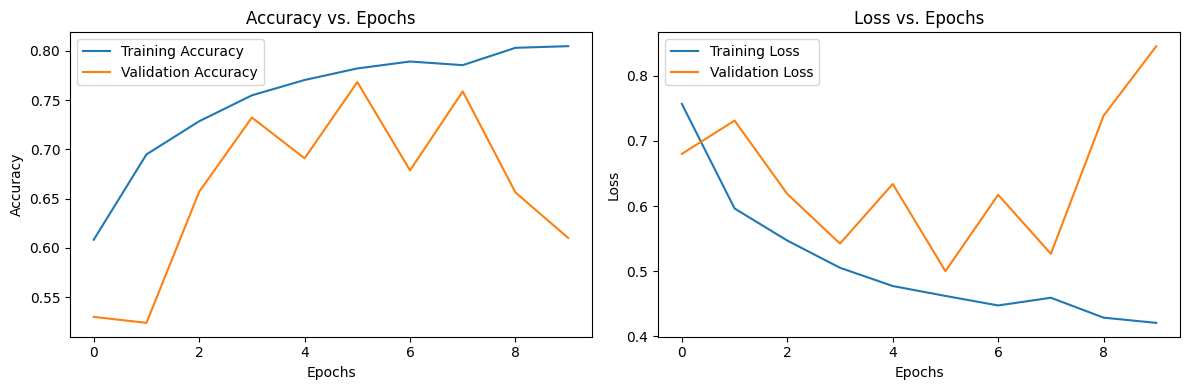

In [26]:
import matplotlib.pyplot as plt


# Plotting the learning curve (accuracy vs. epochs)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(model.history['accuracy'], label='Training Accuracy')
plt.plot(model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the loss curve (loss vs. epochs)
plt.subplot(1, 2, 2)
plt.plot(model.history['loss'], label='Training Loss')
plt.plot(model.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
classifier.save("model.h5")
print("Saved model to disk")

Saved model to disk


c:\Users\navee\anaconda3\envs\dog_cat_classification\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
from keras.models import load_model

loaded_model = load_model("model.h5")

In [29]:

from keras.preprocessing import image
test_image = image.load_img(r'E:\DATA\dog_cat_CNN\test1\test1\11.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = loaded_model.predict(test_image)

if result[0][0] == 1:
    prediction = 'dog'
    print(prediction)
else:
    prediction = 'cat'
    print(prediction)

1/1 [==============================] - 0s 245ms/step
dog
